In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

2025-02-15 14:25:32.964084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [3]:
'''
        Each file contains nine columns and a different number of rows depending on the test length.
        
        1st column is the acceleration data in the X axis measured by the sensor ADXL345.
        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.
        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.

        4th column is the rotation data in the X axis measured by the sensor ITG3200.
        5th column is the rotation data in the Y axis measured by the sensor ITG3200.
        6th column is the rotation data in the Z axis measured by the sensor ITG3200.

        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.
        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.
        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.
        
        Data are in bits with the following characteristics:

        ADXL345:
        Resolution: 13 bits
        Range: +-16g

        ITG3200
        Resolution: 16 bits
        Range: +-2000°/s

        MMA8451Q:
        Resolution: 14 bits
        Range: +-8g
'''

'\n        Each file contains nine columns and a different number of rows depending on the test length.\n        \n        1st column is the acceleration data in the X axis measured by the sensor ADXL345.\n        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.\n        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.\n\n        4th column is the rotation data in the X axis measured by the sensor ITG3200.\n        5th column is the rotation data in the Y axis measured by the sensor ITG3200.\n        6th column is the rotation data in the Z axis measured by the sensor ITG3200.\n\n        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.\n        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.\n        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.\n        \n        Data are in bits with the following characteristics:\

In [4]:
datapath = "./data/SisFall.csv"

df = pd.read_csv(datapath, index_col=0)
df.head(10)

,ADXL_x,ADXL_y,ADXL_z,ITG_x,ITG_y,ITG_z,MMA_x,MMA_y,MMA_z,subject,activity,trial
NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,SA01,D01,R01
0.0,17.0,-179.0,-99.0,-18.0,-504.0,-352.0,76.0,-697.0,-279.0,SA01,D01,R01
1.0,15.0,-174.0,-90.0,-53.0,-568.0,-306.0,48.0,-675.0,-254.0,SA01,D01,R01
2.0,1.0,-176.0,-81.0,-84.0,-613.0,-271.0,-2.0,-668.0,-221.0,SA01,D01,R01
3.0,-10.0,-180.0,-77.0,-104.0,-647.0,-227.0,-34.0,-697.0,-175.0,SA01,D01,R01
4.0,-21.0,-191.0,-63.0,-128.0,-675.0,-191.0,-74.0,-741.0,-133.0,SA01,D01,R01
5.0,-37.0,-225.0,-59.0,-146.0,-700.0,-159.0,-110.0,-840.0,-103.0,SA01,D01,R01
6.0,-36.0,-243.0,-46.0,-166.0,-722.0,-131.0,-147.0,-948.0,-75.0,SA01,D01,R01
7.0,-44.0,-271.0,-38.0,-190.0,-738.0,-107.0,-171.0,-1073.0,-38.0,SA01,D01,R01
8.0,-51.0,-312.0,-33.0,-210.0,-752.0,-90.0,-200.0,-1191.0,3.0,SA01,D01,R01


In [5]:
print (df.columns)
print (set(df['subject']))
features = df.copy()

# dnum = 200
# fnum = 365

Index(['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z', 'MMA_x',
       'MMA_y', 'MMA_z', 'subject', 'activity', 'trial'],
      dtype='object')
{'SA06', 'SA20', 'SA07', 'SA04', 'SA10', 'SA19', 'SA13', 'SA02', 'SA22', 'SE12', 'SE03', 'SE10', 'SE14', 'SA08', 'SA23', 'SE15', 'SA05', 'SA15', 'SA17', 'SA14', 'SA21', 'SE09', 'SE13', 'SE07', 'SA09', 'SA16', 'SE05', 'SE04', 'SE06', 'SA18', 'SE11', 'SA11', 'SA01', 'SA03', 'SE08', 'SA12', 'SE02', 'SE01'}


In [6]:
def drop_outlier(features) :
    sensor_columns = [col for col in features.columns if col not in ['activity', 'subject', 'trial']]
    
    z_scores = pd.DataFrame(index=features.index)
    for col in sensor_columns:
        z_scores[col] = (features[col] - features[col].mean()) / features[col].std()
    
    mask = (np.abs(z_scores) < 3).all(axis=1)
    filtered_features = features[mask].copy()
    
    print(f"original : {len(features)}")
    print(f"after : {len(filtered_features)}")
    print(f"number of deleted data : {len(features) - len(filtered_features)}")
    
    return filtered_features

features = drop_outlier(df)

original : 15838429
after : 14906814
number of deleted data : 931615


In [7]:
D01 = features[(features['activity']=='D01') & (features['subject']=='SA01')].copy()
D02 = features[(features['activity']=='D02') & (features['subject']=='SA01')].copy()
D03 = features[(features['activity']=='D03') & (features['subject']=='SA01')].copy()
D04 = features[(features['activity']=='D04') & (features['subject']=='SA01')].copy()
D05 = features[(features['activity']=='D05') & (features['subject']=='SA01')].copy()
D06 = features[(features['activity']=='D06') & (features['subject']=='SA01')].copy()
D07 = features[(features['activity']=='D07') & (features['subject']=='SA01')].copy()
D08 = features[(features['activity']=='D08') & (features['subject']=='SA01')].copy()
D09 = features[(features['activity']=='D09') & (features['subject']=='SA01')].copy()
D10 = features[(features['activity']=='D10') & (features['subject']=='SA01')].copy()
D11 = features[(features['activity']=='D11') & (features['subject']=='SA01')].copy()
D12 = features[(features['activity']=='D12') & (features['subject']=='SA01')].copy()
D13 = features[(features['activity']=='D13') & (features['subject']=='SA01')].copy()
D14 = features[(features['activity']=='D14') & (features['subject']=='SA01')].copy()
D15 = features[(features['activity']=='D15') & (features['subject']=='SA01')].copy()
D16 = features[(features['activity']=='D16') & (features['subject']=='SA01')].copy()
D17 = features[(features['activity']=='D17') & (features['subject']=='SA01')].copy()
D18 = features[(features['activity']=='D18') & (features['subject']=='SA01')].copy()
D19 = features[(features['activity']=='D19') & (features['subject']=='SA01')].copy()

In [8]:
F01 = features[(features['activity']=='F01') & (features['subject']=='SA01')].copy()
F02 = features[(features['activity']=='F02') & (features['subject']=='SA01')].copy()
F03 = features[(features['activity']=='F03') & (features['subject']=='SA01')].copy()
F04 = features[(features['activity']=='F04') & (features['subject']=='SA01')].copy()
F05 = features[(features['activity']=='F05') & (features['subject']=='SA01')].copy()
F06 = features[(features['activity']=='F06') & (features['subject']=='SA01')].copy()
F07 = features[(features['activity']=='F07') & (features['subject']=='SA01')].copy()
F08 = features[(features['activity']=='F08') & (features['subject']=='SA01')].copy()
F09 = features[(features['activity']=='F09') & (features['subject']=='SA01')].copy()
F10 = features[(features['activity']=='F10') & (features['subject']=='SA01')].copy()
F11 = features[(features['activity']=='F11') & (features['subject']=='SA01')].copy()
F12 = features[(features['activity']=='F12') & (features['subject']=='SA01')].copy()
F13 = features[(features['activity']=='F13') & (features['subject']=='SA01')].copy()
F14 = features[(features['activity']=='F14') & (features['subject']=='SA01')].copy()
F15 = features[(features['activity']=='F15') & (features['subject']=='SA01')].copy()

In [9]:
df = pd.DataFrame()
df = pd.concat([df, F01, F02, F03, F04, F05, F06, F07, F08, F09, F10, F11, F12, F13, F14, F15])
df = pd.concat([df, D01, D02, D03, D04, D05, D06, D07, D08, D09, D10, D11, D15, D16, D17, D18, D19])

In [10]:
df['activity'].value_counts()

activity
D05    24697
D17    24649
D06    23317
D01    19973
D02    18097
F14    14793
F11    14664
F15    14558
F12    14519
F09    14511
F13    14490
F08    14483
F10    14371
F07    14281
F01    14167
F03    14161
F02    14157
F04    13978
F06    13754
D03    13203
F05    12051
D07    12005
D15    12005
D16    12005
D09    11998
D19    11884
D08    11876
D11    11866
D10    11864
D18    11507
D04     7221
Name: count, dtype: int64

In [11]:
features = df.copy()

In [12]:
features = features.replace({'activity':'D01'},0)
features = features.replace({'activity':'D01'},0)
features = features.replace({'activity':'D02'},0)
features = features.replace({'activity':'D03'},0)
features = features.replace({'activity':'D04'},0)
features = features.replace({'activity':'D05'},0)
features = features.replace({'activity':'D06'},0)
features = features.replace({'activity':'D07'},0)
features = features.replace({'activity':'D08'},0)
features = features.replace({'activity':'D09'},0)
features = features.replace({'activity':'D10'},0)
features = features.replace({'activity':'D11'},0)
features = features.replace({'activity':'D12'},0)
features = features.replace({'activity':'D13'},0)
features = features.replace({'activity':'D14'},0)
features = features.replace({'activity':'D15'},0)
features = features.replace({'activity':'D16'},0)
features = features.replace({'activity':'D17'},0)
features = features.replace({'activity':'D18'},0)
features = features.replace({'activity':'D19'},0)
features = features.replace({'activity':'F01'},1)
features = features.replace({'activity':'F02'},1)
features = features.replace({'activity':'F03'},1)
features = features.replace({'activity':'F04'},1)
features = features.replace({'activity':'F05'},1)
features = features.replace({'activity':'F06'},1)
features = features.replace({'activity':'F07'},1)
features = features.replace({'activity':'F08'},1)
features = features.replace({'activity':'F09'},1)
features = features.replace({'activity':'F10'},1)
features = features.replace({'activity':'F11'},1)
features = features.replace({'activity':'F12'},1)
features = features.replace({'activity':'F13'},1)
features = features.replace({'activity':'F14'},1)
features = features.replace({'activity':'F15'},1)
features = features.replace({'activity':'F15'},1)

/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_83673/4220643108.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.replace({'activity':'F15'},1)


In [13]:
features['activity'].value_counts()

activity
0    238167
1    212938
Name: count, dtype: int64

In [14]:
features

,ADXL_x,ADXL_y,ADXL_z,ITG_x,ITG_y,ITG_z,MMA_x,MMA_y,MMA_z,subject,activity,trial
NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,SA01,1,R01
0.0,-9.0,-257.0,-25.0,84.0,247.0,27.0,-120.0,-987.0,63.0,SA01,1,R01
1.0,-3.0,-263.0,-23.0,99.0,258.0,35.0,-110.0,-1016.0,68.0,SA01,1,R01
2.0,-1.0,-270.0,-22.0,114.0,272.0,45.0,-94.0,-1037.0,69.0,SA01,1,R01
3.0,1.0,-277.0,-24.0,127.0,286.0,57.0,-81.0,-1062.0,69.0,SA01,1,R01
...,...,...,...,...,...,...,...,...,...,...,...,...
2395.0,5.0,-258.0,-67.0,-36.0,-5.0,-5.0,2.0,-1002.0,-144.0,SA01,0,R05
2396.0,1.0,-260.0,-67.0,-37.0,-5.0,-6.0,-5.0,-1000.0,-143.0,SA01,0,R05
2397.0,-2.0,-258.0,-67.0,-37.0,-5.0,-7.0,-8.0,-1003.0,-142.0,SA01,0,R05
2398.0,1.0,-258.0,-66.0,-38.0,-5.0,-6.0,4.0,-1002.0,-143.0,SA01,0,R05


In [15]:
print (set(features['subject']))

{'SA01'}


In [16]:
features = features[[ft for ft in features.columns if ft not in ['subject', 'trial']]]
print(features.columns)

Index(['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z', 'MMA_x',
       'MMA_y', 'MMA_z', 'activity'],
      dtype='object')


In [17]:
from sklearn.preprocessing import StandardScaler

feature_columns = [col for col in features.columns if col != 'activity']

scaler = StandardScaler()

features_scaled = features.copy()
features_scaled[feature_columns] = scaler.fit_transform(features[feature_columns])

In [18]:
adl_count = features_scaled['activity'].value_counts()[0]
fall_count = features_scaled['activity'].value_counts()[1]

adl_mask = features_scaled['activity'] == 0
adl_data = features_scaled[adl_mask]
adl1 = adl_data.iloc[:int(adl_count * 0.6)]
adl2 = adl_data.iloc[int(adl_count * 0.6):]

fall_mask = features_scaled['activity'] == 1
fall_data = features_scaled[fall_mask]
fall1 = fall_data.iloc[:int(fall_count * 0.6)]
fall2 = fall_data.iloc[int(fall_count * 0.6):]

print(adl1.shape, adl2.shape, fall1.shape, fall2.shape)

(142900, 10) (95267, 10) (127762, 10) (85176, 10)


In [19]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [20]:
WINDOW_LENGTH = 100
STRIDE = 25
train_data, train_labels = split_sequences(adl1, 
                                           WINDOW_LENGTH, 
                                          STRIDE)
print (f"after train(only adl) : {train_data.shape}")
print (train_labels.shape)

normal_test_data, normal_test_labels = split_sequences(adl2, 
                                                       WINDOW_LENGTH, 
                                                       STRIDE)
abnormal_test_data, abnormal_test_labels = split_sequences(fall2, 
                                                           WINDOW_LENGTH,
                                                           STRIDE)
print (f"after test adl(normal) : {normal_test_data.shape, normal_test_labels.shape}")
print (f"after test fall(abnormal) : {abnormal_test_data.shape, abnormal_test_labels.shape}")

after train(only adl) : (5713, 100, 9)
(5713,)
after test adl(normal) : ((3807, 100, 9), (3807,))
after test fall(abnormal) : ((3404, 100, 9), (3404,))


----

In [21]:
EPOCHS = 100
INITIAL_LEARNING_RATE = 1e-4  
DECAY_STEPS = 1000  
DECAY_RATE = 0.98  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

In [22]:
class SisFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [23]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        middle_channels = out_channels // 2
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, middle_channels, kernel_size=2, padding='same'),
            nn.BatchNorm1d(middle_channels),
            nn.ReLU(),
            nn.Conv1d(middle_channels, out_channels, kernel_size=2, padding='same'),
            nn.BatchNorm1d(out_channels),   
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)

In [24]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [25]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, in_channels=9):
        super().__init__()
        # Encoder path
        self.inc = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.GELU()
        )  # [B, 64, 100]
        
        self.down = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.GELU()
        )  # [B, 128, 50]
        
        # Decoder path
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(128, 64, kernel_size=3, padding='same'),
            nn.BatchNorm1d(64),
            nn.GELU()
        )  # [B, 64, 100]

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # [B, 64, 100]
        x2 = self.down(x1)    # [B, 128, 50]
        # Decoder
        x3 = self.up(x2)      # [B, 64, 100]
        
        return x2, (x1, x3)   # bottleneck: [B, 128, 50], skip: ([B, 64, 100], [B, 64, 100])


In [26]:
# class TransformerEncoder(nn.Module):
#     def __init__(self, embed_dim=128, num_heads=8, num_layers=4):
#         super().__init__()
#         self.layers = nn.ModuleList([
#             nn.TransformerEncoderLayer(
#                 d_model=embed_dim,
#                 nhead=num_heads,
#                 dim_feedforward=embed_dim*4,
#                 dropout=0.1,
#                 batch_first=True
#             ) for _ in range(num_layers)
#         ])
        
#         self.pos_embedding = nn.Parameter(torch.zeros(1, 100//4, embed_dim))

#     def forward(self, x):
#         B, C, L = x.shape
#         x = x.transpose(1, 2)
#         x = x + self.pos_embedding
        
#         for layer in self.layers:
#             x = layer(x)
            
#         return x.transpose(1, 2)

class PCAEncoder(nn.Module):
    def __init__(self, n_components=64):
        super().__init__()
        self.n_components = n_components
        self.pca = None
        self.trained = False
        
    def fit(self, x):
        # x shape: [batch_size, channels, seq_length]
        B, C, L = x.shape
        # Reshape for PCA: [batch_size * seq_length, channels]
        x_reshaped = x.transpose(1, 2).reshape(-1, C)
        
        # Perform PCA
        from sklearn.decomposition import PCA
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(x_reshaped.cpu().detach().numpy())
        self.trained = True
        
    def forward(self, x):
        # x shape: [batch_size, channels, seq_length]
        if not self.trained:
            self.fit(x)
            
        B, C, L = x.shape
        # Reshape for PCA transform
        x_reshaped = x.transpose(1, 2).reshape(-1, C)
        
        # Transform data
        x_transformed = self.pca.transform(x_reshaped.cpu().detach().numpy())
        x_transformed = torch.FloatTensor(x_transformed).to(x.device)
        
        # Reshape back: [batch_size, seq_length, n_components]
        x_final = x_transformed.reshape(B, L, self.n_components)
        
        # Return shape: [batch_size, n_components, seq_length]
        return x_final.transpose(1, 2)

In [27]:
class PCATransUNet1D(nn.Module):
    def __init__(self, in_channels=9):
        super().__init__()
        self.cnn_encoder = CNNFeatureExtractor(in_channels)
        self.pca_encoder = PCAEncoder(n_components=128)  # Match bottleneck dimension
        
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(128),
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )
        
        # Decoder
        self.up2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2),  # [B, 64, 100]
            DoubleConv(128, 64)  # 128 from concatenation (64+64)
        )
        
        self.up1 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, padding='same'),
            DoubleConv(64, 32)   # 64 from concatenation (32+32)
        )
        
        self.final_conv = nn.Conv1d(32, in_channels, kernel_size=1)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t)
        
        # CNN features
        features, skip_connections = self.cnn_encoder(x)  # features: [B, 128, 50]
        x1, x2 = skip_connections  # x1, x2: [B, 64, 100]
        
        # Add time information
        features = features + t_emb.unsqueeze(-1)
        
        # PCA encoding
        features = self.pca_encoder(features)  # [B, 128, 50]
        
        # Decoder with skip connections
        x = self.up2[0](features)  # [B, 64, 100]
        x = torch.cat([x, x2], dim=1)  # [B, 128, 100]
        x = self.up2[1](x)  # [B, 64, 100]
        
        x = self.up1[0](x)  # [B, 32, 100]
        x = torch.cat([x, torch.zeros_like(x)], dim=1)  # [B, 64, 100]
        x = self.up1[1](x)  # [B, 32, 100]
        
        return self.final_conv(x)  # [B, 9, 100]

In [28]:
class DDPM:
    def __init__(self, num_timesteps=1000): 
        self.num_timesteps = num_timesteps
        # Cosine schedule
        betas = torch.linspace(-6, 6, num_timesteps)
        betas = torch.sigmoid(betas) * (0.5e-2 - 1e-4) + 1e-4
        self.betas = betas
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
    def q_sample(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Samples from q(x_t | x_0) = N(x_t; √(αₜ)x₀, (1-αₜ)I)
        """
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None]
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod[t])[:, None, None]
        epsilon = torch.randn_like(x_0)
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * epsilon, epsilon
    
    def sample_t(self, batch_size):
        """
        Uniformly sample timesteps t
        """
        return torch.randint(0, self.num_timesteps, (batch_size,))
        
    def p_sample(self, model, batch_size, device, shape):
        """
        Reverse diffusion process: p_θ(x_{t-1} | x_t)
        Generate samples using the reverse process
        """
        model.eval()
        with torch.no_grad():
            x_t = torch.randn(batch_size, *shape).to(device)
            
            for t in reversed(range(1, self.num_timesteps)):
                time_tensor = torch.ones(batch_size, dtype=torch.long).to(device) * t
                
                # Predict noise
                predicted_noise = model(x_t, time_tensor)
                
                alpha = self.alphas[t][:, None, None]
                alpha_cumprod = self.alphas_cumprod[t][:, None, None]
                beta = self.betas[t][:, None, None]
                
                # Add noise for stochasticity
                noise = torch.randn_like(x_t)
                
                # Compute mean for p_θ(x_{t-1} | x_t)
                x_t = 1 / torch.sqrt(alpha) * (
                    x_t - (1 - alpha) / torch.sqrt(1 - alpha_cumprod) * predicted_noise
                ) + torch.sqrt(beta) * noise
                
        model.train()
        return x_t

In [29]:
def train_ddpm(model, train_loader, ddpm, optimizer, scheduler, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        n_batches = len(train_loader)
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            
            optimizer.zero_grad()
            t = ddpm.sample_t(batch_size).to(device)
            x_t, epsilon = ddpm.q_sample(x_0, t)
            epsilon_theta = model(x_t, t)
            loss = F.mse_loss(epsilon_theta, epsilon)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / n_batches
        print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')

In [30]:
model = PCATransUNet1D().to(device)
ddpm = DDPM(num_timesteps=1000)  
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print("Train data shape:", train_data.shape)

train_dataset = SisFallDataset(train_data)
sample_data = train_dataset[0]
print("Dataset sample shape:", sample_data.shape)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
first_batch = next(iter(train_loader))
print("Batch shape:", first_batch.shape)

train_ddpm(
    model=model,
    train_loader=train_loader,
    ddpm=ddpm,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=EPOCHS,
    device=device
)

Train data shape: (5713, 100, 9)
Dataset sample shape: torch.Size([9, 100])
Batch shape: torch.Size([32, 9, 100])


Epoch 1/100:   0%|                                      | 0/179 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv1d(input, weight, bias, self.stride,
Epoch 1/100: 100%|████████████████████████████| 179/179 [00:09<00:00, 18.06it/s]


Epoch 1/100 - Avg Loss: 1.0048


Epoch 2/100: 100%|████████████████████████████| 179/179 [00:09<00:00, 17.98it/s]


Epoch 2/100 - Avg Loss: 0.8924


Epoch 3/100: 100%|████████████████████████████| 179/179 [00:09<00:00, 19.14it/s]


Epoch 3/100 - Avg Loss: 0.8266


Epoch 4/100: 100%|████████████████████████████| 179/179 [00:09<00:00, 18.71it/s]


Epoch 4/100 - Avg Loss: 0.7763


Epoch 5/100: 100%|████████████████████████████| 179/179 [00:09<00:00, 17.97it/s]


Epoch 5/100 - Avg Loss: 0.7338


Epoch 6/100: 100%|████████████████████████████| 179/179 [00:09<00:00, 17.95it/s]


Epoch 6/100 - Avg Loss: 0.7014


Epoch 7/100: 100%|████████████████████████████| 179/179 [00:09<00:00, 18.55it/s]


Epoch 7/100 - Avg Loss: 0.6740


Epoch 8/100: 100%|████████████████████████████| 179/179 [00:10<00:00, 17.31it/s]


Epoch 8/100 - Avg Loss: 0.6500


Epoch 9/100: 100%|████████████████████████████| 179/179 [00:10<00:00, 17.20it/s]


Epoch 9/100 - Avg Loss: 0.6304


Epoch 10/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.34it/s]


Epoch 10/100 - Avg Loss: 0.6078


Epoch 11/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.10it/s]


Epoch 11/100 - Avg Loss: 0.5899


Epoch 12/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.99it/s]


Epoch 12/100 - Avg Loss: 0.5715


Epoch 13/100: 100%|███████████████████████████| 179/179 [00:12<00:00, 14.63it/s]


Epoch 13/100 - Avg Loss: 0.5535


Epoch 14/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.15it/s]


Epoch 14/100 - Avg Loss: 0.5360


Epoch 15/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.09it/s]


Epoch 15/100 - Avg Loss: 0.5218


Epoch 16/100: 100%|███████████████████████████| 179/179 [00:11<00:00, 15.43it/s]


Epoch 16/100 - Avg Loss: 0.5110


Epoch 17/100: 100%|███████████████████████████| 179/179 [00:11<00:00, 15.22it/s]


Epoch 17/100 - Avg Loss: 0.4928


Epoch 18/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.92it/s]


Epoch 18/100 - Avg Loss: 0.4824


Epoch 19/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.44it/s]


Epoch 19/100 - Avg Loss: 0.4685


Epoch 20/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.88it/s]


Epoch 20/100 - Avg Loss: 0.4600


Epoch 21/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.02it/s]


Epoch 21/100 - Avg Loss: 0.4463


Epoch 22/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.98it/s]


Epoch 22/100 - Avg Loss: 0.4368


Epoch 23/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.96it/s]


Epoch 23/100 - Avg Loss: 0.4275


Epoch 24/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.89it/s]


Epoch 24/100 - Avg Loss: 0.4176


Epoch 25/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.59it/s]


Epoch 25/100 - Avg Loss: 0.4098


Epoch 26/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.70it/s]


Epoch 26/100 - Avg Loss: 0.4009


Epoch 27/100: 100%|███████████████████████████| 179/179 [00:11<00:00, 15.50it/s]


Epoch 27/100 - Avg Loss: 0.3949


Epoch 28/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.30it/s]


Epoch 28/100 - Avg Loss: 0.3847


Epoch 29/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.87it/s]


Epoch 29/100 - Avg Loss: 0.3812


Epoch 30/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.64it/s]


Epoch 30/100 - Avg Loss: 0.3710


Epoch 31/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.91it/s]


Epoch 31/100 - Avg Loss: 0.3661


Epoch 32/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.98it/s]


Epoch 32/100 - Avg Loss: 0.3605


Epoch 33/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.32it/s]


Epoch 33/100 - Avg Loss: 0.3561


Epoch 34/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.76it/s]


Epoch 34/100 - Avg Loss: 0.3491


Epoch 35/100: 100%|███████████████████████████| 179/179 [00:11<00:00, 15.23it/s]


Epoch 35/100 - Avg Loss: 0.3445


Epoch 36/100: 100%|███████████████████████████| 179/179 [00:11<00:00, 15.71it/s]


Epoch 36/100 - Avg Loss: 0.3389


Epoch 37/100: 100%|███████████████████████████| 179/179 [00:11<00:00, 15.88it/s]


Epoch 37/100 - Avg Loss: 0.3370


Epoch 38/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.36it/s]


Epoch 38/100 - Avg Loss: 0.3304


Epoch 39/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.43it/s]


Epoch 39/100 - Avg Loss: 0.3234


Epoch 40/100: 100%|███████████████████████████| 179/179 [00:12<00:00, 14.78it/s]


Epoch 40/100 - Avg Loss: 0.3184


Epoch 41/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.44it/s]


Epoch 41/100 - Avg Loss: 0.3154


Epoch 42/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.42it/s]


Epoch 42/100 - Avg Loss: 0.3105


Epoch 43/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.78it/s]


Epoch 43/100 - Avg Loss: 0.3102


Epoch 44/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.69it/s]


Epoch 44/100 - Avg Loss: 0.3060


Epoch 45/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.80it/s]


Epoch 45/100 - Avg Loss: 0.3010


Epoch 46/100: 100%|███████████████████████████| 179/179 [00:11<00:00, 15.80it/s]


Epoch 46/100 - Avg Loss: 0.2959


Epoch 47/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.38it/s]


Epoch 47/100 - Avg Loss: 0.2940


Epoch 48/100: 100%|███████████████████████████| 179/179 [00:09<00:00, 17.94it/s]


Epoch 48/100 - Avg Loss: 0.2929


Epoch 49/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.83it/s]


Epoch 49/100 - Avg Loss: 0.2916


Epoch 50/100: 100%|███████████████████████████| 179/179 [00:09<00:00, 17.90it/s]


Epoch 50/100 - Avg Loss: 0.2909


Epoch 51/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.83it/s]


Epoch 51/100 - Avg Loss: 0.2852


Epoch 52/100: 100%|███████████████████████████| 179/179 [00:09<00:00, 17.93it/s]


Epoch 52/100 - Avg Loss: 0.2821


Epoch 53/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.08it/s]


Epoch 53/100 - Avg Loss: 0.2779


Epoch 54/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.61it/s]


Epoch 54/100 - Avg Loss: 0.2786


Epoch 55/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.44it/s]


Epoch 55/100 - Avg Loss: 0.2775


Epoch 56/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.43it/s]


Epoch 56/100 - Avg Loss: 0.2737


Epoch 57/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.69it/s]


Epoch 57/100 - Avg Loss: 0.2751


Epoch 58/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.75it/s]


Epoch 58/100 - Avg Loss: 0.2743


Epoch 59/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.57it/s]


Epoch 59/100 - Avg Loss: 0.2731


Epoch 60/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.42it/s]


Epoch 60/100 - Avg Loss: 0.2714


Epoch 61/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.25it/s]


Epoch 61/100 - Avg Loss: 0.2689


Epoch 62/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.32it/s]


Epoch 62/100 - Avg Loss: 0.2681


Epoch 63/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.33it/s]


Epoch 63/100 - Avg Loss: 0.2683


Epoch 64/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.65it/s]


Epoch 64/100 - Avg Loss: 0.2691


Epoch 65/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.08it/s]


Epoch 65/100 - Avg Loss: 0.2633


Epoch 66/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.41it/s]


Epoch 66/100 - Avg Loss: 0.2615


Epoch 67/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.43it/s]


Epoch 67/100 - Avg Loss: 0.2658


Epoch 68/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.31it/s]


Epoch 68/100 - Avg Loss: 0.2602


Epoch 69/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.27it/s]


Epoch 69/100 - Avg Loss: 0.2597


Epoch 70/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.01it/s]


Epoch 70/100 - Avg Loss: 0.2600


Epoch 71/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.17it/s]


Epoch 71/100 - Avg Loss: 0.2569


Epoch 72/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.37it/s]


Epoch 72/100 - Avg Loss: 0.2611


Epoch 73/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.34it/s]


Epoch 73/100 - Avg Loss: 0.2585


Epoch 74/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.25it/s]


Epoch 74/100 - Avg Loss: 0.2534


Epoch 75/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.35it/s]


Epoch 75/100 - Avg Loss: 0.2569


Epoch 76/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.92it/s]


Epoch 76/100 - Avg Loss: 0.2560


Epoch 77/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.07it/s]


Epoch 77/100 - Avg Loss: 0.2586


Epoch 78/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.37it/s]


Epoch 78/100 - Avg Loss: 0.2540


Epoch 79/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.19it/s]


Epoch 79/100 - Avg Loss: 0.2575


Epoch 80/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.23it/s]


Epoch 80/100 - Avg Loss: 0.2543


Epoch 81/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.12it/s]


Epoch 81/100 - Avg Loss: 0.2532


Epoch 82/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.87it/s]


Epoch 82/100 - Avg Loss: 0.2537


Epoch 83/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.23it/s]


Epoch 83/100 - Avg Loss: 0.2507


Epoch 84/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.16it/s]


Epoch 84/100 - Avg Loss: 0.2541


Epoch 85/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.30it/s]


Epoch 85/100 - Avg Loss: 0.2510


Epoch 86/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.23it/s]


Epoch 86/100 - Avg Loss: 0.2549


Epoch 87/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.79it/s]


Epoch 87/100 - Avg Loss: 0.2533


Epoch 88/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.28it/s]


Epoch 88/100 - Avg Loss: 0.2542


Epoch 89/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.24it/s]


Epoch 89/100 - Avg Loss: 0.2560


Epoch 90/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.24it/s]


Epoch 90/100 - Avg Loss: 0.2532


Epoch 91/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.17it/s]


Epoch 91/100 - Avg Loss: 0.2538


Epoch 92/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.23it/s]


Epoch 92/100 - Avg Loss: 0.2533


Epoch 93/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.76it/s]


Epoch 93/100 - Avg Loss: 0.2538


Epoch 94/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 16.85it/s]


Epoch 94/100 - Avg Loss: 0.2506


Epoch 95/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.03it/s]


Epoch 95/100 - Avg Loss: 0.2499


Epoch 96/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.16it/s]


Epoch 96/100 - Avg Loss: 0.2519


Epoch 97/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.22it/s]


Epoch 97/100 - Avg Loss: 0.2511


Epoch 98/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.22it/s]


Epoch 98/100 - Avg Loss: 0.2535


Epoch 99/100: 100%|███████████████████████████| 179/179 [00:10<00:00, 17.10it/s]


Epoch 99/100 - Avg Loss: 0.2526


Epoch 100/100: 100%|██████████████████████████| 179/179 [00:10<00:00, 17.53it/s]

Epoch 100/100 - Avg Loss: 0.2532


------

In [31]:
class SisFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [32]:
def detect_anomalies(model, ddpm, data_loader, device, threshold=None):
    model.eval()
    anomaly_scores = []

    with torch.no_grad():
        for batch in data_loader:
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]

            t = ddpm.sample_t(batch_size).to(device)

            x_t, epsilon = ddpm.q_sample(x_0, t)

            epsilon_theta = model(x_t, t)

            # MSE Loss (Anomaly Score)
            loss = F.mse_loss(epsilon_theta, epsilon, reduction='none')
            loss = loss.mean(dim=(1, 2)) 
            anomaly_scores.extend(loss.cpu().numpy())  

    if threshold is None:
        threshold = np.percentile(anomaly_scores, 95)

    anomalies = [score > threshold for score in anomaly_scores]

    return anomalies, anomaly_scores, threshold


In [33]:
normal_dataset = SisFallDataset(normal_test_data)
normal_loader = DataLoader(normal_dataset, batch_size=BATCH_SIZE)

abnormal_dataset = SisFallDataset(abnormal_test_data)
abnormal_loader = DataLoader(abnormal_dataset, batch_size=BATCH_SIZE)

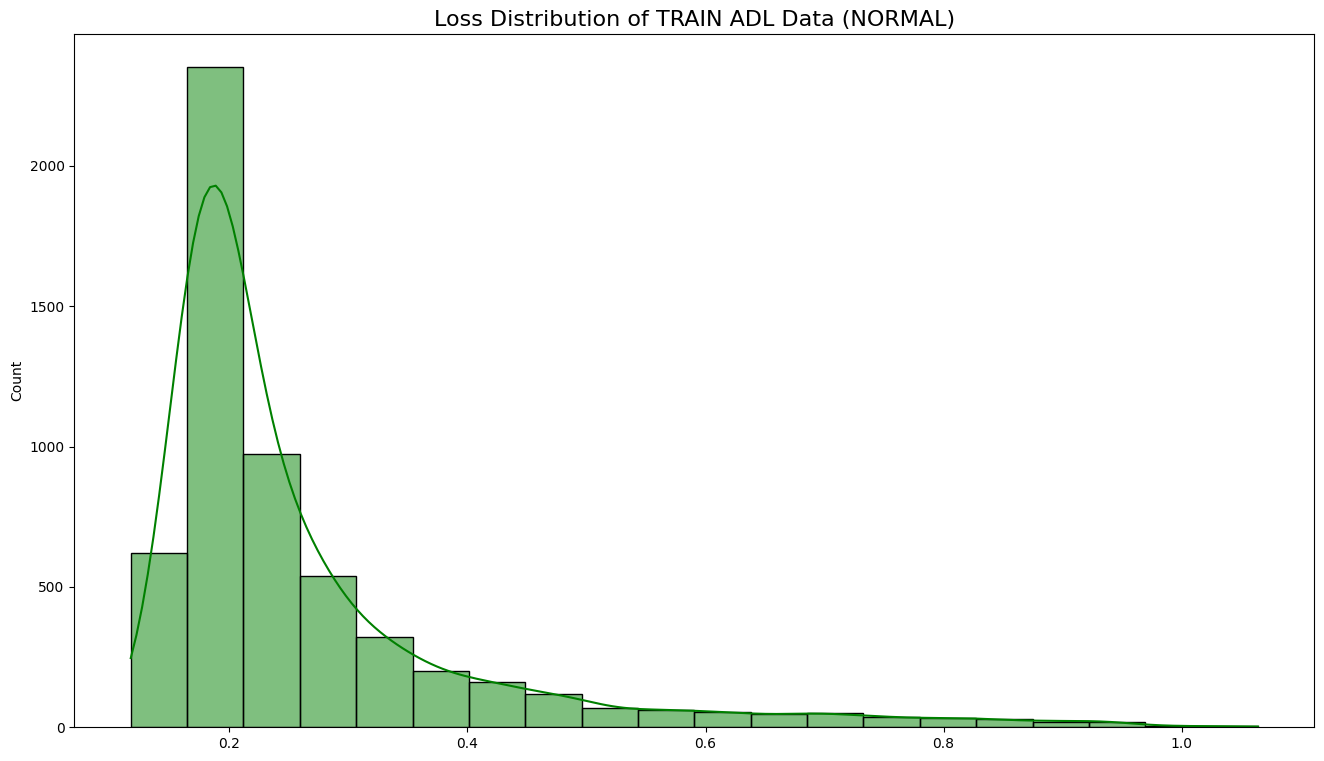

In [34]:
train_dataset = SisFallDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

train_anomalies, train_scores, _ = detect_anomalies(model, ddpm, train_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TRAIN ADL Data (NORMAL)', fontsize=16)
sns.histplot(train_scores, bins=20, kde=True, color='green')
plt.show()

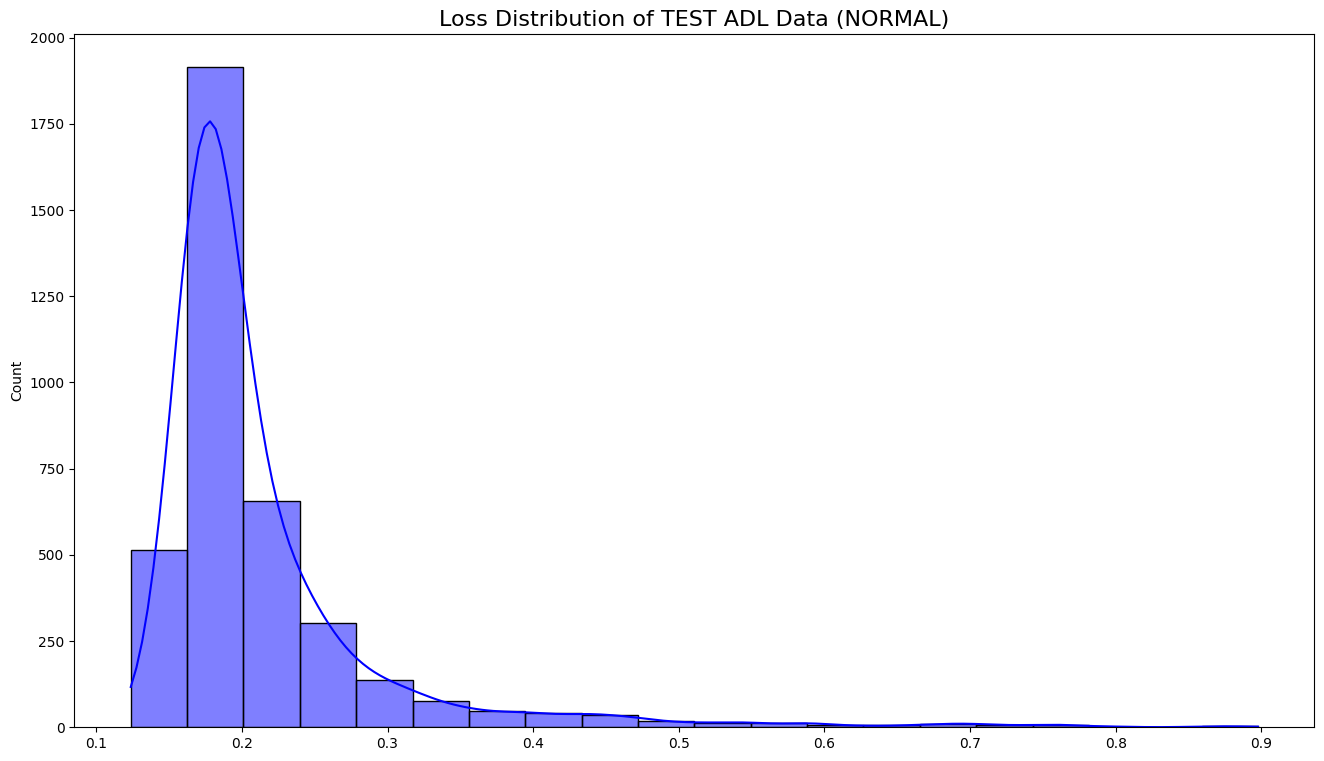

In [35]:
normal_anomalies, normal_scores, _ = detect_anomalies(model, ddpm, normal_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TEST ADL Data (NORMAL)', fontsize=16)
sns.histplot(normal_scores, bins=20, kde=True, color='blue')
plt.show()

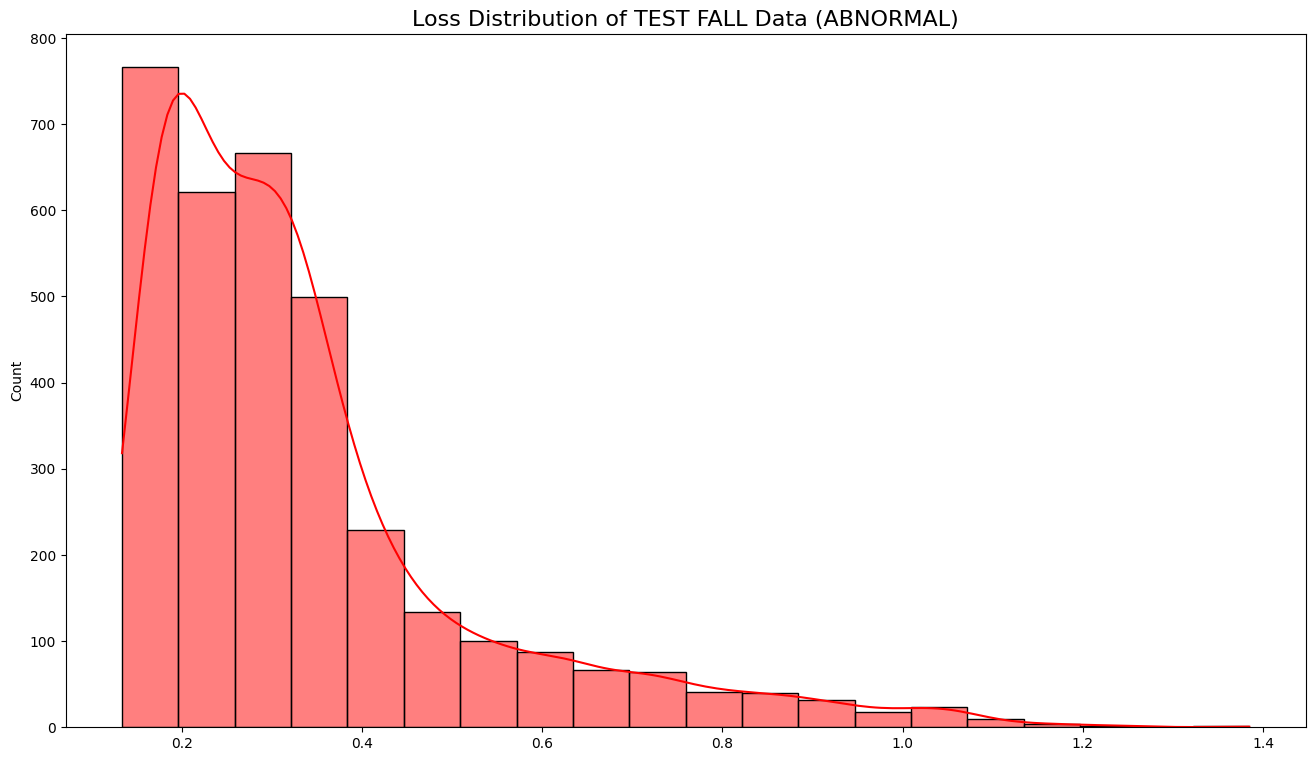

In [36]:
abnormal_anomalies, abnormal_scores, _ = detect_anomalies(model, ddpm, abnormal_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TEST FALL Data (ABNORMAL)', fontsize=16)
sns.histplot(abnormal_scores, bins=20, kde=True, color='red')
plt.show()

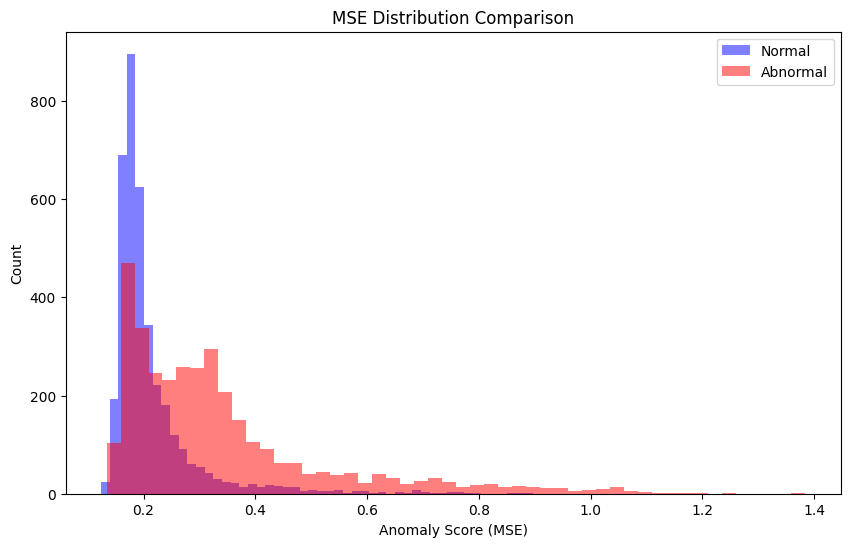

In [37]:
plt.figure(figsize=(10,6))
plt.title('MSE Distribution Comparison')
plt.hist(normal_scores, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores, bins=50, alpha=0.5, color='red', label='Abnormal')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()
plt.show()

In [38]:
error_df = pd.DataFrame({
    'reconstruction_error': np.concatenate([normal_scores, abnormal_scores]),
    'true_class': np.concatenate([np.zeros(len(normal_scores)), np.ones(len(abnormal_scores))])
})

print ("error dataframe head : ")
print(error_df.head(10))
print ()
print ("error dataframe tail : ")
print(error_df.tail(10))
print ()
print(error_df.describe())
print ()
error_df['true_class'].value_counts()

error dataframe head : 
   reconstruction_error  true_class
0              0.262768         0.0
1              0.245241         0.0
2              0.163400         0.0
3              0.176994         0.0
4              0.185505         0.0
5              0.241901         0.0
6              0.274521         0.0
7              0.299120         0.0
8              0.436882         0.0
9              0.296262         0.0

error dataframe tail : 
      reconstruction_error  true_class
7201              0.255506         1.0
7202              0.337163         1.0
7203              0.330594         1.0
7204              0.552582         1.0
7205              0.292835         1.0
7206              0.757996         1.0
7207              0.346732         1.0
7208              0.328126         1.0
7209              0.366605         1.0
7210              0.953613         1.0

       reconstruction_error   true_class
count           7211.000000  7211.000000
mean               0.272832     0.472057
st

true_class
0.0    3807
1.0    3404
Name: count, dtype: int64

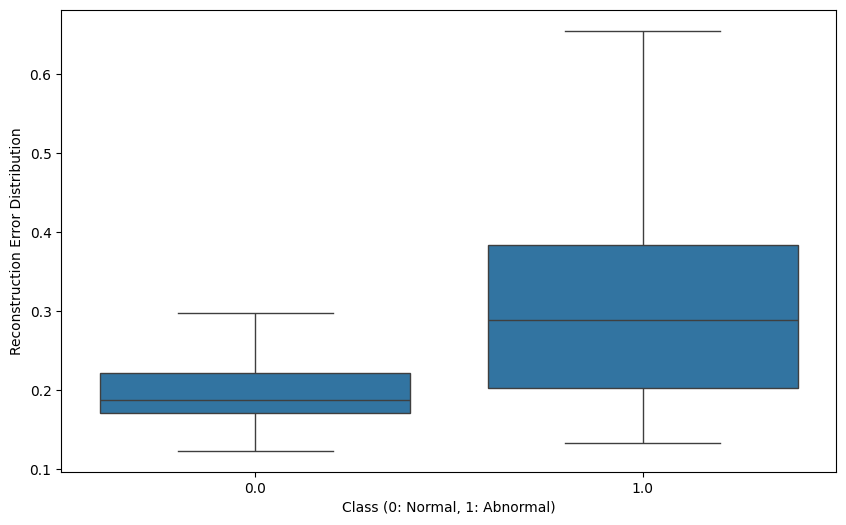

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df, showfliers=False)
plt.ylabel('Reconstruction Error Distribution')
plt.xlabel('Class (0: Normal, 1: Abnormal)')
plt.show()

In [40]:
threshold = np.percentile(normal_scores, 80)

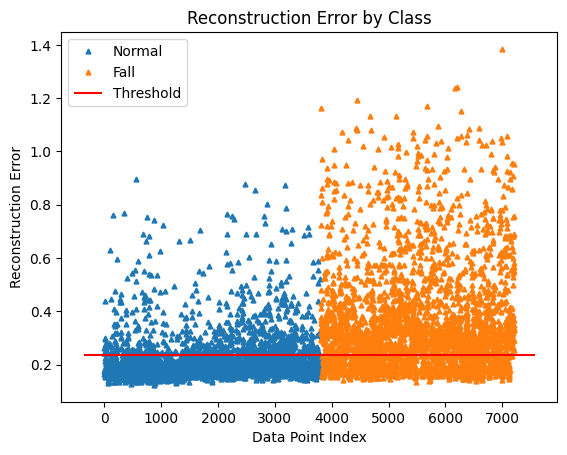

In [41]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label="Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()

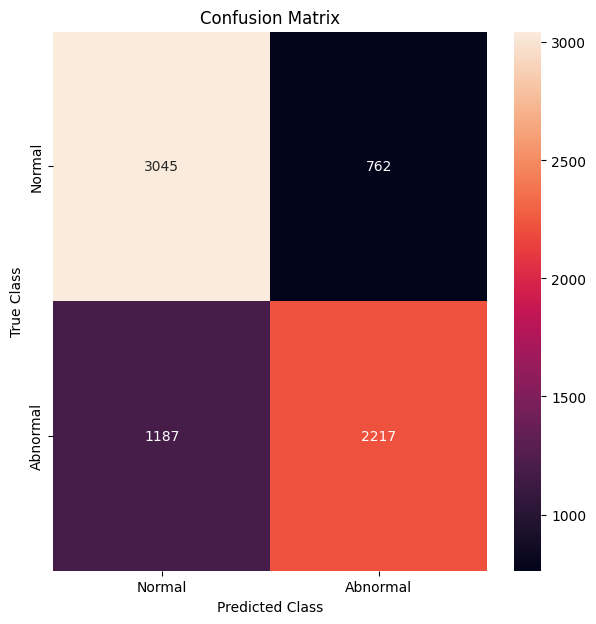

In [42]:
LABELS = ["Normal", "Abnormal"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [43]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(error_df.true_class, y_pred, average='binary')
accuracy = accuracy_score(error_df.true_class, y_pred)

print('\nPerformance Metrics:')
print(f'Accuracy Score : {accuracy:.4f}')
print(f'Precision     : {precision:.4f}')
print(f'Recall        : {recall:.4f}')
print(f'F1 Score      : {f1:.4f}')


Performance Metrics:
Accuracy Score : 0.7297
Precision     : 0.7442
Recall        : 0.6513
F1 Score      : 0.6947
